ECE194N/594N HW2: Shapes

Mikolaj Godzik and Jose Nunez

In this project, we will be visualzing a dataset for our final project, in which we will be classifying cell cycle stages, using cell nuclei and membrane shape as predictors. The dataset examined here comes from the following paper: https://www.nature.com/articles/s41586-022-05563-7, specifically, the supplementary dataset that coantains labeled data of 5,664 cells, which may be accessed here: https://open.quiltdata.com/b/allencell/packages/aics/mitotic_annotation. 
The dataset consists of raw microscopy images of cells with 3 channels: nuclear dye, membrane dye, and a single, endogenous protein tagged with a fluorescent protein, as well as segmented, binary images of the same cells, consisting of 2 channels: nuclear dye binary segmentation and membrane dye binary segmentation. We will be examining the latter set of images, as all pre-processing and segmentation have alreadyh been implemented for these images.

# 1. Installing libraries, downloading data, exploring metadata


In [ ]:
pip install aicsimageio

In [ ]:
pip install opencv-python

In [ ]:
pip install geomstats

In [ ]:
pip install quilt3

In [5]:
import pandas as pd
import numpy as np
import quilt3 as q3
import matplotlib.pyplot as plt
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
import cv2

In [ ]:
q3.Package.install("aics/mitotic_annotation", path="metadata.csv", registry="s3://allencell", dest=".")

In [ ]:
q3.Package.install("aics/mitotic_annotation", path="crop_seg", registry="s3://allencell", dest=".")

In [8]:
meta = pd.read_csv('metadata.csv')
meta.head()

,CellId,label,crop_raw,crop_seg
0,af726df3-a641-4cec-897c-5a5a3ce9d70f,blob,crop_raw/8cefb076_raw.ome.tif,crop_seg/1119158e_segmentation.ome.tif
1,89c3aabd-1a38-4ec8-ba26-ca86706a948c,blob,crop_raw/0480229d_raw.ome.tif,crop_seg/fc03204c_segmentation.ome.tif
2,591b317b-b6c4-4a7d-a602-494bb919e4e5,blob,crop_raw/5bba3b6a_raw.ome.tif,crop_seg/a79c4e8d_segmentation.ome.tif
3,2f71b11c-cf78-4285-9c19-f6702feeb225,blob,crop_raw/e60cc3bd_raw.ome.tif,crop_seg/dbd8fa8d_segmentation.ome.tif
4,f409a4ec-2141-492d-a506-9d0ed8f0f6c7,blob,crop_raw/8b1cc874_raw.ome.tif,crop_seg/70f426dd_segmentation.ome.tif


As seen above, the metadata column contains path files for the raw and segmented images, as well as labels for each cell. All unique labels are shown below

In [9]:
print(meta['label'].unique())

['blob' 'dead' 'wrong' 'M0' 'M1M2' 'M3' 'M4M5' 'M6M7_half' 'M6M7_early']


These labels should be sufficient for training our learning model. The label 'blob' refers to intracellular dye aggregates, rather than true cells. 'Wrong' refers to cells that were incorrevtly segmented. 'Dead' refers to cells that had died or were in the process of dying during imaging. These outlier cells will not be used for classification of cell cycle stage. The rest of the labels refer to a specific stage of the cell cycle that the cell was in during imaging. Finally, the column 'CellId' refers to a unique label for each cell imaged. 

In [10]:
print(meta['label'].value_counts())

M0            2516
M4M5           927
M3             823
M6M7_half      561
M1M2           441
M6M7_early     338
dead           103
wrong           35
blob            20
Name: label, dtype: int64


The vast majority of cells do not belong to any outlier groups (2.7% total). Overall, the dataset is biased towards M0, or interphase cells (~44% of total dataset). 

# 2. Visualizing Images

In [ ]:
paths_dict = {}
for label in list(meta['label'].unique()):
  path = str(meta[meta['label']==str(label)].iloc[3]['crop_seg'].strip('crop_seg/'))
  reader_label = AICSImage(path)
  img_label = reader_label.data.astype(np.float32)
  im_data_label = reader_label.get_image_data("CYX",Z=45,S=0, T=0,dimension_order='CYX')
  paths_dict[label] = [path,im_data_label]

In [ ]:
fig, ax = plt.subplots(figsize = (25,25),nrows=len(paths_dict),ncols=2)
i = 0
for label in paths_dict:
  ax[i,0].imshow(paths_dict[label][1][0,:,:], cmap = 'gray')
  ax[i,0].set_title('Nucleus, Label = {}'.format(label))
  ax[i,1].imshow(paths_dict[label][1][1,:,:], cmap = 'gray')
  ax[i,1].set_title('Membrane, Label = {}'.format(label))
  i = i + 1
plt.tight_layout()
plt.show()

Shown above is a sample of cell images, one from each unique label, with the leftmost row representing the nuclear binary channel, and the rightmost row representing the membrane binary channel. We see a potential problem with our dataset: some cells, such as the one shown with label M6M7_half, have round, continuous/smooth nuclei, while others, such as the one shown with label M3, have discrete punctae-like segmented nuclei. 

# 3. Parametrization

In [165]:
lis = [2886,2887,2888,2889,2900]#[158,159,160,166,162,
       #2886,2887,2888,2889,2900,
       #3787,3788,3789,3790,3791,
       #4089,4090,4091,4092,4093,
       #5391,5392,5393,5394,5395,
       #5588,5589,5590,5591,5592]

In [ ]:
#counter = 0
# number of parametrization points per cell
#para_size = 50
# dim = number of cells, nuclear vs membrane, points on curve, x vs y
#cells = np.zeros((len(lis),2,para_size,2))

#for i in lis:
  # read in images from local and extract 32nd Z slices
  #reader = AICSImage(meta['crop_seg'][i].replace('crop_seg/','')) 
  #img = reader.data.astype(np.float32)
  #im_data = reader.get_image_data("CYX",Z=32,S=0, T=0,dimension_order='CYX')

# NUCLEAR
  # set cutoff for nuclear size (avoids errors in parametrization)
  '''
  What is the best value for this cut off?
  '''
  #if im_data[0,:,:].mean() < 7:
    #cntr = np.zeros((para_size,2))
    
  #else:
    # paramatrize the nuclear boundary curve
    #contours = cv2.findContours(im_data[0,:,:], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #contours = contours[0] if len(contours) == 2 else contours[1]
    #if len(contours) == 2 and len(contours[1]) > len(contours[0]):
      #cntr = contours[1]
    #else:
      #cntr = contours[0]
    #cntr = np.asarray(cntr)
    #cntr = np.reshape(cntr,(cntr.shape[0],2))
    # this code randomly picks points in order to resize the parametrization to a specific length
    #choice = np.random.choice(range(cntr.shape[0]), size=(para_size,1), replace=False)
    #ind = np.zeros(cntr.shape[0], dtype=bool)
    #ind[choice] = True
    #cntr = cntr[ind]

# MEMBRANE
  #if im_data[1,:,:].mean() < 7:
    #cntr_mem = np.zeros((para_size,2))
  #else:
    #contours_mem = cv2.findContours(im_data[1,:,:], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #contours_mem = contours_mem[0] if len(contours_mem) == 2 else contours_mem[1]
    #if len(contours_mem) == 2 and len(contours_mem[1]) > len(contours_mem[0]):
      #cntr_mem = contours_mem[1]
    #else:
      #cntr_mem = contours_mem[0]
    #cntr_mem = np.asarray(cntr_mem)
    #cntr_mem = np.reshape(cntr_mem,(cntr_mem.shape[0],2))
    #choice_mem = np.random.choice(range(cntr_mem.shape[0]), size=(para_size,1), replace=False)
    #ind_mem = np.zeros(cntr_mem.shape[0], dtype=bool)
    #ind_mem[choice_mem] = True
    #cntr_mem = cntr_mem[ind_mem]
  
  #new = np.stack((cntr,cntr_mem),axis=0)
  #cells[counter,:,:,:] = new
  #counter += 1

In [21]:
#np.save('data_subset.npy',cells)
cells = np.load('data_subset.npy')

In [22]:
labels = meta['label']
row_names = meta['label'].unique()[3:]

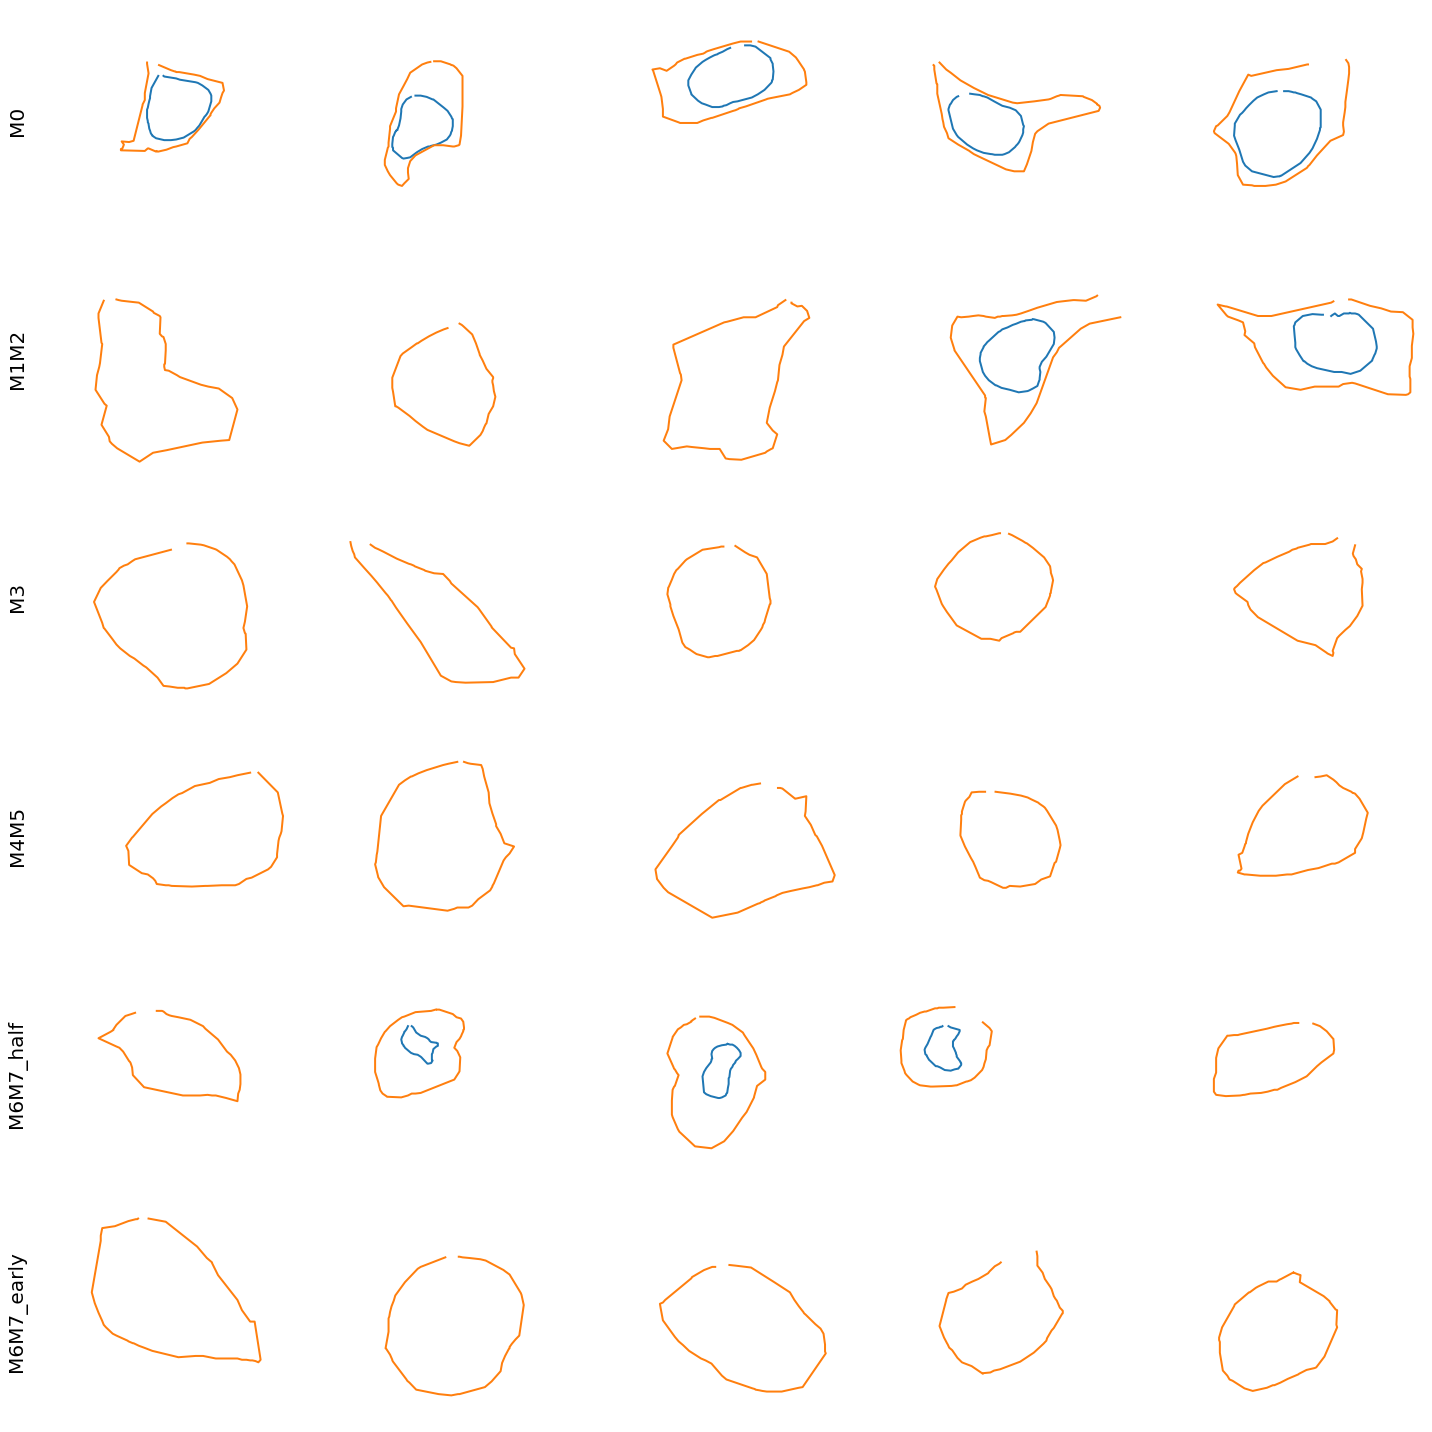

In [23]:
p = 0
fig, ax = plt.subplots(nrows=6, ncols=5,
                       sharex=True, sharey=True,
                       figsize=(20, 20))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        
        col.plot(cells[p,0,:,0],-cells[p,0,:,1],linewidth=2)
        col.plot(cells[p,1,:,0],-cells[p,1,:,1],linewidth=2)
        col.axes.xaxis.set_ticks([])
        col.axes.yaxis.set_ticks([])
        col.spines['top'].set_visible(False)
        col.spines['bottom'].set_visible(False)
        col.spines['left'].set_visible(False)
        col.spines['right'].set_visible(False)
        if j == 0:
            col.set_ylabel(row_names[i],fontsize=20)
        p += 1
plt.tight_layout()

Shown above are sample images of cells, with the foreground of the image parametrized.